
#  Generative Adversarial Networks (GANs) 

### Einleitung

Generative Adversarial Networks (GANs) sind eine Klasse von maschinellen Lernmodellen, die erstmals 2014 von Ian Goodfellow und seinen Kollegen eingeführt wurden. Sie bestehen aus zwei neuralen Netzwerken – einem Generator und einem Diskriminator – die gegeneinander antreten. Diese Netzwerke können verwendet werden, um realistische Daten zu generieren, die dem Trainingsdatensatz ähneln.

### Funktionsweise von GANs

#### Grundprinzip
Ein GAN besteht aus zwei konkurrierenden Netzwerken:

- **Generator (G)**: Erzeugt neue Dateninstanzen, die den Trainingsdaten ähneln.
- **Diskriminator (D)**: Bewertet, ob die Daten echt oder vom Generator erzeugt wurden.

Das Ziel des Generators ist es, den Diskriminator zu täuschen, indem er so realistisch wie möglich erscheinende Daten erzeugt. Der Diskriminator versucht hingegen, echte Daten von gefälschten zu unterscheiden. Dies wird als Minimax-Spiel beschrieben, wobei beide Netzwerke ständig verbessert werden, um ihren jeweiligen Aufgaben besser nachzukommen.

#### Mathematische Formulierung
Die Verlustfunktion eines GANs wird durch folgende Gleichung beschrieben:

$$ \min_G \max_D V(D,G) = E_{x \sim p_{data}(x)} [ \log D(x) ] + E_{z \sim p_z(z)} [ \log (1 - D(G(z))) ] $$

### Wiso anwendung von Fréchet Inception Distance (FID) in meinem Code

Der Fréchet Inception Distance (FID) ist eine Metrik, die häufig zur Bewertung der Qualität von generierten Daten verwendet wird. Der FID-Wert vergleicht die Verteilung der echten Daten mit der Verteilung der generierten Daten. Ein niedrigerer FID-Wert deutet darauf hin, dass die generierten Daten den echten Daten ähnlicher sind.

#### Berechnung des FID

Der FID berechnet die Differenz der Mittelwerte und Kovarianzmatrizen der echten und generierten Datenverteilungen. Diese Berechnung erfolgt mittels der folgenden Gleichung:

$$
\text{FID} = \| \mu_r - \mu_g \|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}) 
$$

wobei $\mu_r$ und $\Sigma_r$ die Mittelwert- und Kovarianzmatrix der echten Daten und $\mu_g$ und $\Sigma_g$ die entsprechenden Parameter der generierten Daten darstellen. Der FID wird oft mit Merkmalen berechnet, die von einem vortrainierten Inception-Netzwerk extrahiert wurden, was die Robustheit und Verlässlichkeit der Bewertung verbessert.

#### Bedeutung des FID

Die Verwendung des FID ist wichtig, weil er über die reine Bewertung der Diskriminatorleistung hinausgeht. Während der Diskriminator nur zwischen echten und generierten Daten unterscheidet, bewertet der FID die tatsächliche Ähnlichkeit der Verteilungen. Dies ermöglicht eine umfassendere und aussagekräftigere Bewertung der Qualität der generierten Daten.

### Training des Modells

Das Modell wurde über 500 Epochen hinweg trainiert, wobei der FID als Metrik zur Bewertung der Leistung verwendet wurde. Da der FID konvergiert ist, kann davon ausgegangen werden, dass es sich um ein gutes Modell handelt.

In [70]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
from scipy.linalg import sqrtm
import numpy as np
from torchvision.models import inception_v3


In [71]:

os.makedirs("images", exist_ok=True)
os.makedirs("models", exist_ok=True)




latent_dim = 100  # Dimension des latenten Raums für den Generator
batch_size = 128  # Größe der Mini-Batches
epochs = 2 # Anzahl der Trainingsdurchläufe
lr = 0.0002  # Lernrate für den Optimierer
beta1 = 0.5  # Betawert für den Adam-Optimierer
start_epoch = 0  # Startepoch, falls von einem Checkpoint geladen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True) # MNIST-Datensatz laden
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)   # Dataloader erstellen


In [72]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),  # Eingangsschicht: 784 (28x28 Pixel)
            nn.LeakyReLU(0.2),  # LeakyReLU-Aktivierung
            nn.Dropout(0.3),  # Dropout zur Regularisierung
            nn.Linear(512, 256),  # Verdeckte Schicht
            nn.LeakyReLU(0.2),  # LeakyReLU-Aktivierung
            nn.Dropout(0.3),  # Dropout zur Regularisierung
            nn.Linear(256, 1),  # Ausgangsschicht
            nn.Sigmoid()  # Sigmoid-Aktivierung zur Ausgabe einer Wahrscheinlichkeit
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)  # Umformung des Eingangsbildes
        return self.model(x)

In [73]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),  # Eingangsschicht: latenter Raum
            nn.ReLU(),  # ReLU-Aktivierung
            nn.Dropout(0.3),  # Dropout zur Regularisierung
            nn.Linear(256, 512),  # Verdeckte Schicht
            nn.ReLU(),  # ReLU-Aktivierung
            nn.Dropout(0.3),  # Dropout zur Regularisierung
            nn.Linear(512, 1024),  # Verdeckte Schicht
            nn.ReLU(),  # ReLU-Aktivierung
            nn.Dropout(0.3),  # Dropout zur Regularisierung
            nn.Linear(1024, 784),  # Ausgangsschicht
            nn.Tanh()  # Tanh-Aktivierung zur Ausgabe von Pixelwerten im Bereich [-1, 1]
        )

    def forward(self, x):
        return self.model(x).view(x.size(0), 1, 28, 28)  # Umformung in Bildformat


In [74]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)  # Eingangsschicht
        self.fc21 = nn.Linear(400, 20)  # Mittelwert-Schicht
        self.fc22 = nn.Linear(400, 20)  # Log-Varianz-Schicht
        self.fc3 = nn.Linear(20, 400)  # Verdeckte Schicht
        self.fc4 = nn.Linear(400, 784)  # Ausgangsschicht

    def encode(self, x):
        h1 = torch.relu(self.fc1(x)) # ReLU-Aktivierung der Eingangsschicht
        return self.fc21(h1), self.fc22(h1) # Ausgabe von Mittelwert und Log-Varianz

    def reparameterize(self, mu, logvar): # Reparametrisierungstrick
        std = torch.exp(0.5 * logvar) # Standardabweichung
        eps = torch.randn_like(std) # Zufälliger Tensor
        return mu + eps * std # Reparametrisierung

    def decode(self, z):   
        h3 = torch.relu(self.fc3(z)) # ReLU-Aktivierung der verdeckten Schicht
        return torch.sigmoid(self.fc4(h3)) # Sigmoid-Aktivierung der Ausgangsschicht

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784)) 
        z = self.reparameterize(mu, logvar) 
        return self.decode(z), mu, logvar 


In [75]:
vae = VAE().to(device)

econstruction_loss = nn.BCELoss(reduction='sum')  # Verlustfunktion zur Rekonstruktion
optimizerVAE = optim.Adam(vae.parameters(), lr=1e-3)  # Adam-Optimierer

D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss()  # Verlustfunktion für den Diskriminator
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))  # Adam-Optimierer für Diskriminator
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))  # Adam-Optimierer für Generator

def load_checkpoint(model, optimizer, filename="checkpoint.pth.tar"):
    start_epoch = 0
    if os.path.isfile(filename):
        print(f"=> Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        print(f"=> Loaded checkpoint '{filename}' (epoch {checkpoint['epoch']})")
    else:
        print(f"=> No checkpoint found at '{filename}'")
    return start_epoch

start_epoch_G = load_checkpoint(G, optimizerG, 'models/G_checkpoint.pth.tar')
start_epoch_D = load_checkpoint(D, optimizerD, 'models/D_checkpoint.pth.tar')
start_epoch_VAE = load_checkpoint(vae, optimizerVAE, 'models/VAE_checkpoint.pth.tar')
start_epoch = max(start_epoch_G, start_epoch_D, start_epoch_VAE)

=> No checkpoint found at 'models/G_checkpoint.pth.tar'
=> No checkpoint found at 'models/D_checkpoint.pth.tar'
=> No checkpoint found at 'models/VAE_checkpoint.pth.tar'


In [76]:
def train_vae(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizerVAE.zero_grad() # Gradienten zurücksetzen
        recon_batch, mu, logvar = vae(data) # Rekonstruktion
        loss = vae_loss_function(recon_batch, data, mu, logvar) # Verlust berechnen
        loss.backward() # Backpropagation
        train_loss += loss.item() # Verlust aufsummieren
        optimizerVAE.step() # Optimierungsschritt
        if batch_idx % 100 == 0: 
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(data_loader.dataset)} ({100. * batch_idx / len(data_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}') 
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(data_loader.dataset):.4f}')

def vae_loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_loss(recon_x, x.view(-1, 784))  # Binäre Kreuzentropie
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # Kullback-Leibler-Divergenz
    return BCE + KLD

In [77]:
def calculate_fid(model, real_images, fake_images):
    # Inception-Modell laden
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    # Bilder auf Größe 299x299 ändern (Eingangsgröße für Inception) und auf 3 Kanäle erweitern
    real_images_resized = F.interpolate(real_images.expand(-1, 3, -1, -1), size=(299, 299), mode='bilinear', align_corners=False)
    fake_images_resized = F.interpolate(fake_images.expand(-1, 3, -1, -1), size=(299, 299), mode='bilinear', align_corners=False)

    # Features extrahieren
    real_features = inception(real_images_resized).detach().cpu().numpy()
    fake_features = inception(fake_images_resized).detach().cpu().numpy()

    # Mittelwert und Kovarianz der Features berechnen
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # FID berechnen
    ssdiff = np.sum((mu_real - mu_fake)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(covmean): # Fallback, falls sqrtm komplexe Zahlen zurückgibt
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean) 
    return fid


In [78]:
d_losses = []
g_losses = []
fid_scores = []

if not os.path.exists('logs/fid_values.txt'):
    open('logs/fid_values.txt', 'w').close()
if not os.path.exists('loss_values.txt'):
    open('logs/loss_values.txt', 'w').close()



In [79]:
with open('logs/fid_values.txt', 'r') as fid_file:
    fid_values = [float(line.strip()) for line in fid_file]

with open('logs/loss_values.txt', 'r') as loss_file:
    loss_values = [tuple(map(float, line.strip().split(','))) for line in loss_file]

for epoch, (fid, (d_loss, g_loss)) in enumerate(zip(fid_values, loss_values), start=1):
    print(f"Epoch {epoch}: FID = {fid}, d_loss = {d_loss}, g_loss = {g_loss}")
    fid_scores.append(fid)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

In [80]:
for epoch in range(start_epoch, epochs):
    for i, (imgs, _) in enumerate(data_loader):
        real_imgs = imgs.to(device)
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)
        z = torch.randn(real_imgs.size(0), latent_dim).to(device)
        fake_imgs = G(z)

        # Training des Diskriminators
        optimizerD.zero_grad()
        outputs = D(real_imgs)
        d_loss_real = criterion(outputs, real_labels)
        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizerD.step()

        # Training des Generators
        optimizerG.zero_grad()
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizerG.step()

    if (epoch+1) == 1:
        images = real_imgs.reshape(real_imgs.size(0), 1, 28, 28)
        save_image(images, './images/real_images.png')

    fake_images = fake_imgs.reshape(fake_imgs.size(0), 1, 28, 28)
    save_image(fake_images, f'./images/fake_images-{epoch+1}.png')


 # FID berechnen
    fid = calculate_fid(inception_v3, real_imgs, fake_imgs)
    fid_scores.append(fid)
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
    print(f'FID after epoch {epoch+1}: {fid:.4f}')

    # Neue FID- und Verlustwerte an Dateien anhängen
    with open('logs/fid_values.txt', 'a') as fid_file:
        fid_file.write(f"{fid}\n")
    with open('logs/loss_values.txt', 'a') as loss_file:
        loss_file.write(f"{d_loss.item()},{g_loss.item()}\n")

    if (epoch + 1) % 10 == 0:
        torch.save(G.state_dict(), f'models/G_epoch{epoch+1}.pth')
        torch.save(D.state_dict(), f'models/D_epoch{epoch+1}.pth')
        torch.save(vae.state_dict(), f'models/VAE_epoch{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': G.state_dict(),
            'optimizer': optimizerG.state_dict(),
        }, 'models/G_checkpoint.pth.tar')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': D.state_dict(),
            'optimizer': optimizerD.state_dict(),
        }, 'models/D_checkpoint.pth.tar')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': vae.state_dict(),
            'optimizer': optimizerVAE.state_dict(),
        }, 'models/VAE_checkpoint.pth.tar')

torch.save(G.state_dict(), 'models/G_final.pth')
torch.save(D.state_dict(), 'models/D_final.pth')
torch.save(vae.state_dict(), 'models/VAE_final.pth')


Epoch [1/2], Step [469/469], d_loss: 0.4869, g_loss: 2.4220
FID after epoch 1: -85634861562357592863497158166969708182964797440.0000
Epoch [2/2], Step [469/469], d_loss: 0.3996, g_loss: 3.2585
FID after epoch 2: -510423550381407695195061911147652317184.0000


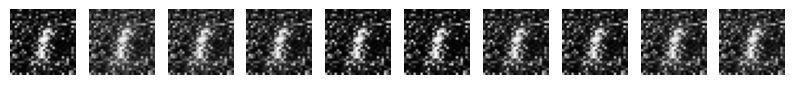

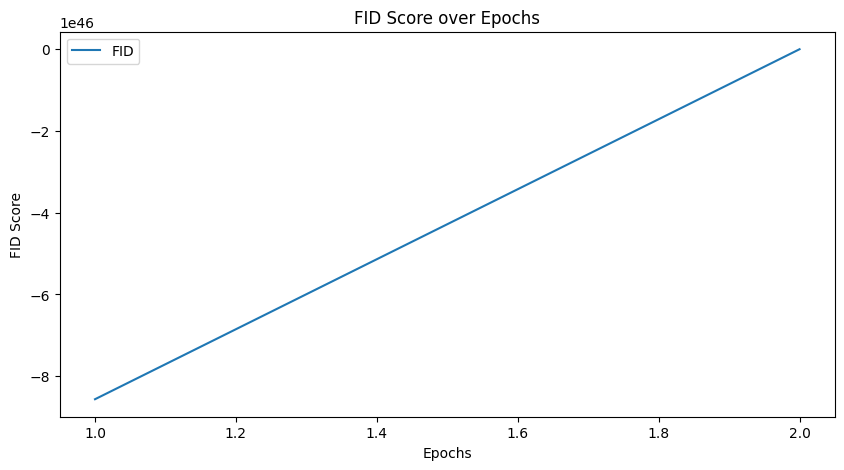

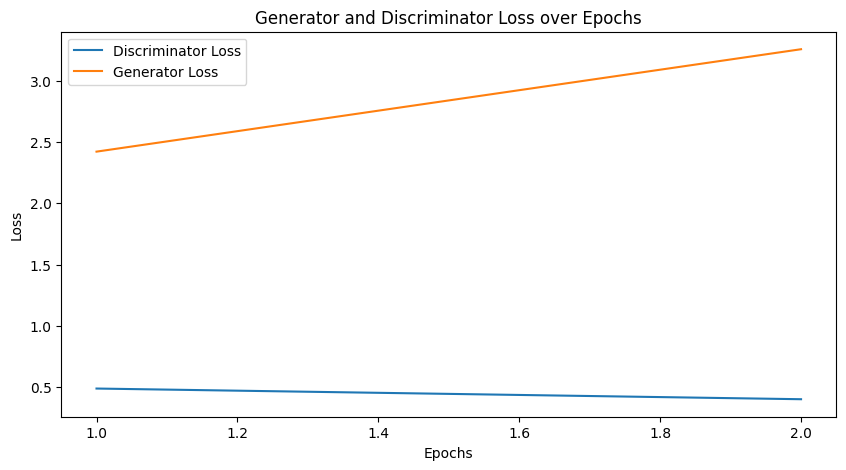

In [81]:
def plot_generated_images(epoch, examples=10):
    z = torch.randn(examples, latent_dim).to(device)
    G.eval()
    with torch.no_grad():
        generated_images = G(z)
    generated_images = generated_images.cpu().detach()
    plt.figure(figsize=(10, 10))
    for i in range(examples):
        plt.subplot(1, examples, i+1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.savefig(f'./images/generated_images_epoch{epoch}.png')
    plt.show()

# Plot images for final epoch
plot_generated_images(epochs)

# Plot FID, d_loss, g_loss, and Inception Score over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fid_scores) + 1), fid_scores, label='FID')
plt.xlabel('Epochs')
plt.ylabel('FID Score')
plt.legend()
plt.title('FID Score over Epochs')
plt.savefig('./images/fid_scores.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(d_losses) + 1), d_losses, label='Discriminator Loss')
plt.plot(range(1, len(g_losses) + 1), g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator and Discriminator Loss over Epochs')
plt.savefig('./images/gan_losses.png')
plt.show()